In [1]:
#1 -- measurements
#2 -- algorithms (Wolff, Metropolis)
#3 -- plots!

using Random

In [2]:
module Measurements

struct Accumulator
    count::Dict{String, UInt64}
    data::Dict{String, Any}
    
    function Accumulator()
        new(Dict{String, UInt64}(), Dict{String, Any}())
    end
end

function add!(acc::Accumulator, name::String, data)
    if haskey(acc.count, name)
        acc.count[name] += 1
        acc.data[name] += data
    else
        acc.count[name] = 1
        acc.data[name] = copy(data)
    end
end
    
function mean(acc::Accumulator, name::String)
    return acc.data[name]/acc.count[name]
end


end

Main.Measurements

In [49]:
abstract type IsingModel end
abstract type Ising_1d <: IsingModel end
abstract type Ising_2d <: IsingModel end
abstract type Ising_3d <: IsingModel end

mutable struct Periodic_1d <: Ising_1d
  num_spins::Int
  state::Array{Int8, 1}
  beta::T where T <: AbstractFloat

  energy::S where S <: AbstractFloat
  average_magnetization::U where U <:AbstractFloat

  function Periodic_1d(
    ns::Int,
    beta::T,
  ) where T <: Real
    @assert ns > 0

    init = rand(Int8[-1, 1], ns)

    energy = 0.0
    @inbounds @simd for i in 1:ns
      energy += init[i] * init[i == ns ? 1 : i+1]
    end
    mag = sum(init) / ns

    new(ns, init, beta, beta * energy, mag)
  end
end

function Hamiltonian(im::Periodic_1d)::Float64
    pair_sum = 0.0
    site_sum = im.h * sum(im.state)

    @inbounds @simd for i in 1:im.num_spins
        pair_sum += im.state[i] * im.state[i == im.num_spins ? 1 : i+1]
    end

    return (-im.beta * pair_sum) - site_sum
end

# Average Magnetization
function AvgMagnetization(im::Periodic_1d)
    return sum(im.state) / (im.num_spins)^2
end

###################################################################3
mutable struct Periodic_2d <: Ising_2d
  num_spins::Int
  state::Array{Int8, 2}
  beta::T where T <: AbstractFloat

  energy::U where U <: AbstractFloat
  average_magnetization::V where V <:AbstractFloat

  function Periodic_2d(
    ns::Int,
    beta::T,
  ) where T <: Real
    @assert ns > 0

    init = rand(Int8[-1, 1], (ns,ns))

    # TODO
    energy = 0.0
    @inbounds @simd for i in 1:ns
      @inbounds @simd for j in 1:ns
        energy += 1
      end
    end

    mag = sum(init) / (ns^2)

    new(ns, init, beta, energy, mag)
  end
end

###################################################################3
mutable struct Periodic_3d <: Ising_3d
  num_spins::Int
  state::Array{Int8, 3}
  beta::T where T <: AbstractFloat

  energy::U where U <: AbstractFloat
  average_magnetization::V where V <:AbstractFloat

  function Periodic_3d(
    ns::Int,
    beta::T,
  ) where T <: Real
    @assert ns > 0
    new(ns, rand(Int8[-1, 1], (ns, ns)), beta)
  end
end

In [50]:
# 1d Metropolis
function neighbors(im::Periodic_1d, i)
    ns = im.num_spins
    return [CartesianIndex(ifelse(i==1, ns, i-1)),
        CartesianIndex(ifelse(i==ns, 1, i+1))]
end


function dEnergy(im::Periodic_1d, i)
    @assert i > 0
    @assert im.num_spins >= i
    nbrs = neighbors(im, i)
    bond_energy = -im.state[i]*(im.state[nbrs[1]] + im.state[nbrs[2]])
            
    return bond_energy
end

function Metropolis!(im::Periodic_1d, niters::Int=Int64(1e5))
    @assert niters > 0
    ns = im.num_spins
    
    @inbounds for _ in 1:niters
        @inbounds for _ in 1:ns
            i = rand(1:ns)
            
            de = -2/im.beta * dEnergy(im, i)
            if (de <= 0 || rand() < exp(-de))
                im.state[i] *= -1
                
                im.energy += de * im.beta
                im.average_magnetization += 2 * im.state[i] * im.state[ns] / ns
            end
        end
    end
end

Metropolis! (generic function with 4 methods)

In [ ]:
function Metropolis!(im, niters, rng)
    min_h = -2
    max_h = 2
    s = im.state
    n = im.num_spins
    prob = [1/(1+exp(-2*(im.beta)*h)) for h in min_h:max_h]
    for iter in 1:niters, i in 1:n
        sl = s[ifelse(i == 1, n, i-1)]
        sr = s[ifelse(i == n, 1, i+1)]
        # h = -2, 0, 2
        h = sl + sr
        si_old = s[i]
        s[i] = ifelse(rand(rng) < prob[h-min_h+1], +1, -1)
        
        # Update observables with O(1) operations
        im.energy += (si_old - s[i]) * h
        im.average_magnetization += (s[i] - si_old)
    end
end

In [11]:
# C ≈ 1 / |T - T_c|^\alpha
function solve!(
    im::T,
    acc::Measurements.Accumulator,
    nsweeps=10^3,
    ntherm=10^4, 
    meas_interval=10^2
) where {T <: Ising_1d}
    
    if mod(nsweeps, meas_interval) != 0
        error("Need nsweeps divisible by interval_meas!")
    end
    
    # thermalization steps
    Metropolis!(im, ntherm)
    
    # Measurement sweeps
    @inbounds for imeas in 1:(nsweeps/meas_interval)
        Metropolis!(im, meas_interval)
        Measurements.add!(acc, "E", Float64(im.energy))
        Measurements.add!(acc, "E2", Float64((im.energy)^2))
    end
end

solve! (generic function with 4 methods)

In [53]:
Ts_mc = range(0.4, 2, length=10)
C_mc = Float64[]
for T in Ts_mc
    imi = Periodic_1d(100, T)
    acc = Measurements.Accumulator()
    solve!(imi, acc, 10^5, 10^4, 10)
    E = Measurements.mean(acc, "E")
    E2 = Measurements.mean(acc, "E2")
    push!(C_mc, (E2 - E^2)/T^2)
end



In [40]:
Ts = range(0.1, 2, length=100)
exact_C(T) = 1/(T * cosh(1/T))^2

exact_C (generic function with 1 method)

In [ ]:
using Plots

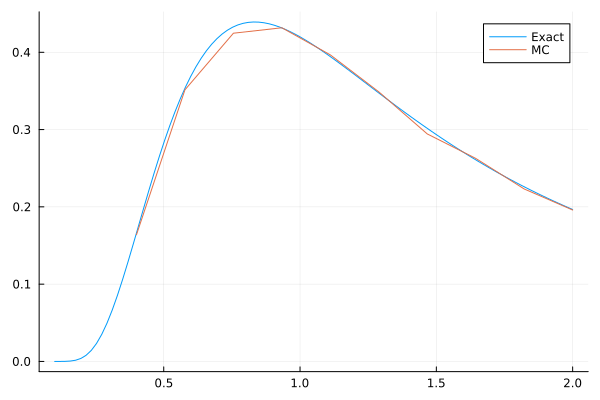

In [54]:
Plots.plot(Ts, exact_C.(Ts), label="Exact")
Plots.plot!(Ts_mc, C_mc ./ 100, label="MC")

In [55]:
asdf = 1 +
    2 + 3

6

In [56]:
asdf

6

In [ ]:
using Random

In [18]:
global const crit_2d = (2 / log(1 + sqrt(2)))

function neighbors(im::Periodic_2d, i,j)
  ns = im.num_spins
  return [CartesianIndex((ifelse(i==1, ns, i-1), j)),
    CartesianIndex((ifelse(i==ns, 1, i+1), j)),
    CartesianIndex((i, ifelse(j==1, ns, j-1))),
    CartesianIndex((i, ifelse(j==ns, 1, j+1)))]
end

function dEnergy(im::Periodic_2d, i,j)
  nbrs = neighbors(im, i,j)
  
  return -im.state[i,j]*(im.state[nbrs[1]] + im.state[nbrs[2]] + im.state[nbrs[3]] + im.state[nbrs[4]])
end


function Metropolis!(im::Periodic_2d, niters::Int=1000)
    @assert niters > 0
    
    ns = im.num_spins
    
    for _ in 1:niters
        for _ in 1:ns^2
            i = rand(1:ns)
            j = rand(1:ns)
            
            de = -2/im.beta * (dEnergy(im, i,j))
            if (de <= 0 || rand() < exp(-de))
                im.state[i,j] *= -1
                #im.energy += de / (ns^2)
                #im.magnetization += 2.0 * im.state[i,j] * im.state[ns,ns]
            end
        end
    end
    
end

Metropolis! (generic function with 4 methods)

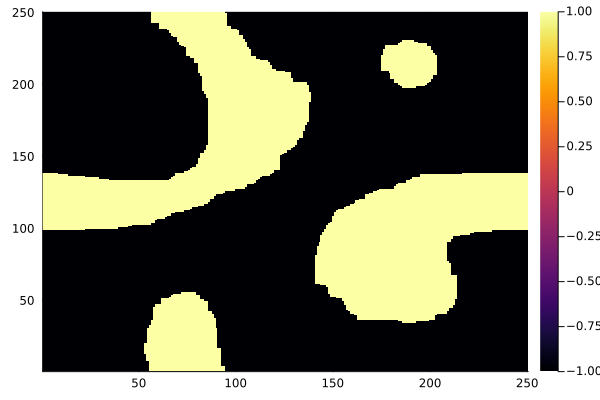

In [20]:
im2 = Periodic_2d(250, 0.00003)
Metropolis!(im2)
heatmap(im2.state)

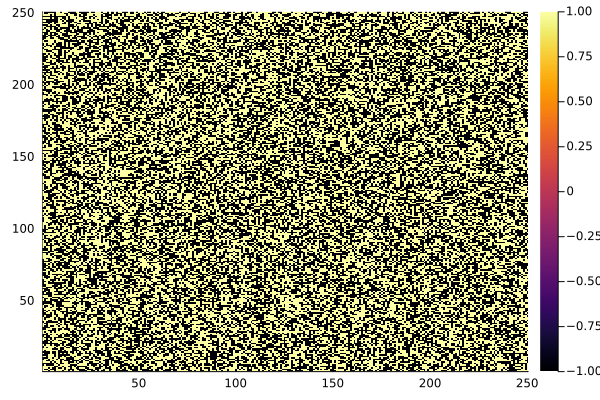

In [23]:
im2 = Periodic_2d(250, 100.0)
Metropolis!(im2)
heatmap(im2.state)

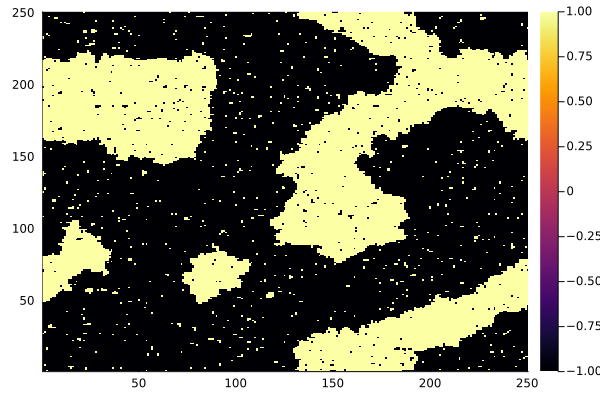

In [22]:
im2 = Periodic_2d(250, 1.8)
Metropolis!(im2)
heatmap(im2.state)

In [ ]:
Metropolis!(im2, 1)
heatmap(im2.state)

In [ ]:
crit_2d

In [24]:
im2.average_magnetization

-0.004832

In [ ]:
Ts_mc = range(0.4, 2, length=10)
C_mc = Float64[]
for T in Ts_mc
    imi = Periodic_2d(250, 1/T)
    acc = Measurements.Accumulator()
    solve!(imi, acc, 10^4, 10^3, 10)
    E = Measurements.mean(acc, "E")
    E2 = Measurements.mean(acc, "E2")
    push!(C_mc, (E2 - E^2)/T^2)
end


In [107]:


function wolff_p_add(beta::T) where T <: AbstractFloat
    return -expm1(-2*beta)
end

function wolff_cluster(im::T, i::CartesianIndex) where {T <: Ising_2d}
    #padd = wolff_p_add(1/im.beta)
    cluster = falses(size(im.state)...)

    queue = [i]
    while !isempty(queue)
        j = pop!(queue)
        for x in neighbors(im, j[1], j[2])
            if !(cluster[x]) && im.state[x] == im.state[j] && rand() < -expm1(-2/im.beta)
                cluster[x] = true
                push!(queue, x)
            end
        end
    end

    return cluster
end



function Wolff!(im::T, niters::Int=10^3) where T <: Ising_2d
    @assert niters > 0
    
    ns = im.num_spins

    for dummy in 1:niters
        i = rand(1:ns)
        j = rand(1:ns)

        curr_coord = CartesianIndex((i,j))

        cluster = wolff_cluster(im, curr_coord)
        cluster_size = sum(cluster)

        ΔM = -2 * im.state[curr_coord] * cluster_size
        im.state .= ifelse.(cluster, im.state .* -1, im.state)

    end
end

Wolff! (generic function with 2 methods)

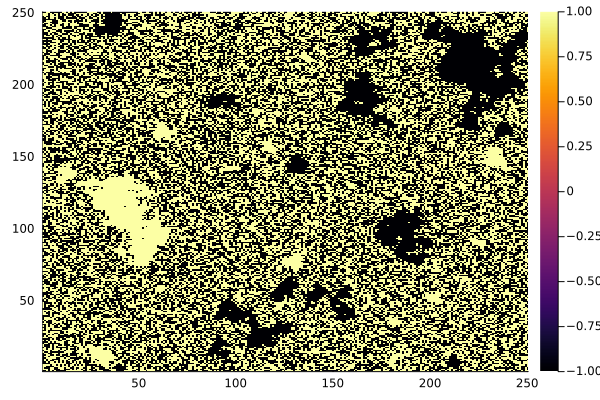

In [135]:
im1 = Periodic_2d(250, 0.003)
Wolff!(im1, 50)
heatmap(im1.state)

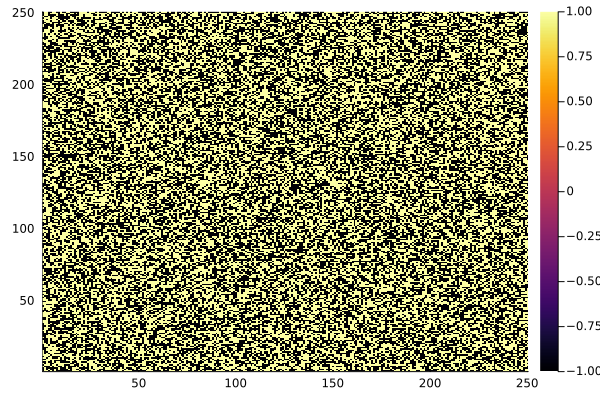

In [121]:
im2 = Periodic_2d(250, 5.0)
Wolff!(im2, 250)
heatmap(im2.state)

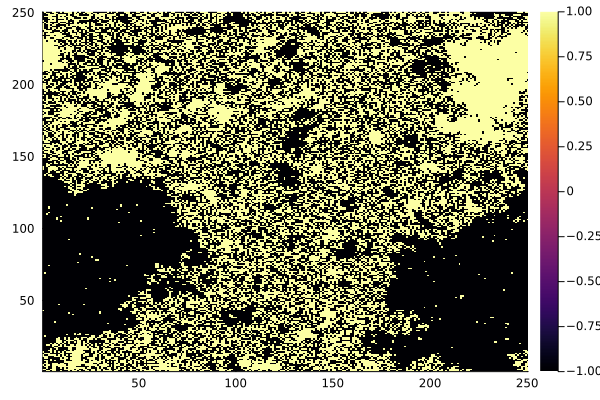

In [123]:
im2 = Periodic_2d(250, 1.5)
Wolff!(im2, 400)
heatmap(im2.state)

In [106]:


-expm1(-2*0.0003)

0.0005998200359946006